In [32]:
import sys
sys.path.append('..')
sys.path.append('../..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM  # perform F test

import selective_recruitment.globals as gl
import Functional_Fusion.dataset as ds 

In [10]:
wk_dir = 'Z:\\data\\Cerebellum\\CerebellumWorkingMemory\\data\\fmri'

In [27]:
# get the behavioral dataframe
df = pd.read_csv(wk_dir + "/df_wm.csv", sep = "\t")
D = df[["isErrorM", "numErrors", "MnumErrors", "NMnumErrors"]]
D["phase"] = df.exec
D["load"] = df.load
D["recall_dir"] = df.seqType
D["sn"] = df.sn
D["isCorrect"] = 1 - D["isErrorM"]

C:\Users\lshah\AppData\Local\Temp\ipykernel_15612\2443647418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["phase"] = df.exec
C:\Users\lshah\AppData\Local\Temp\ipykernel_15612\2443647418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["load"] = df.load
C:\Users\lshah\AppData\Local\Temp\ipykernel_15612\2443647418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load            15.3600 2.0000 30.0000 0.0000
recall_dir       5.4470 1.0000 15.0000 0.0339
load:recall_dir  0.5661 2.0000 30.0000 0.5737



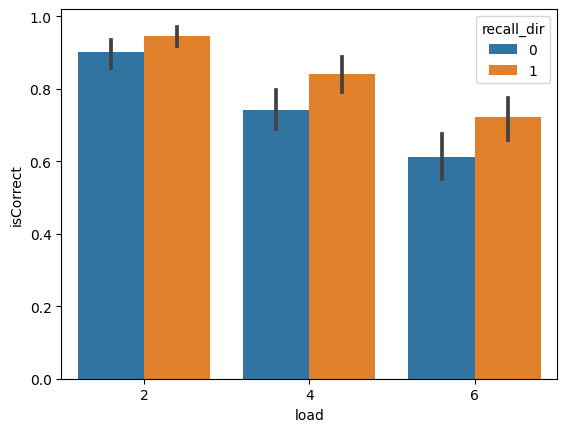

In [33]:
sns.barplot(data = D.loc[D.phase == 1], x = "load", y =  "isCorrect", hue = "recall_dir")
plt.savefig("behaviour_percent_correct.pdf")
print(AnovaRM(data=D.loc[D.phase == 1], depvar='isCorrect',subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())
